In [2]:
import json
import os
import pandas as pd
import numpy as np


# Introduction
The dataset was downloaded from https://www.kaggle.com/datasets/rmisra/news-category-dataset/data.

The data is available as a .json file (News_Category_Dataset_v3.json), which can be read directly into a pandas dataframe with 209527 rows.

2024-02-17: Updated to only do EDA on training dataset (after 80/20 splits to set aside validation and test sets)

In [104]:
# If using Google Colab, upload .json file into root content directory (as per path below) during working session.
# If using a local Jupyter Notebook, edit the paths below to point to your working folder.
# root = '/content' # For Google Colab
root = "/Users/cathytay/60-69-Code/61.06-TextClassification/data"
df = pd.read_json(os.path.join(root, "News_Category_Dataset_v3.json"), lines = True)

In [105]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209527 entries, 0 to 209526
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   link               209527 non-null  object        
 1   headline           209527 non-null  object        
 2   category           209527 non-null  object        
 3   short_description  209527 non-null  object        
 4   authors            209527 non-null  object        
 5   date               209527 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(5)
memory usage: 9.6+ MB


In [106]:
df.head(2) # view data samples

,link,headline,category,short_description,authors,date
0,https://www.huffpost.com/entry/covid-boosters-uptake-us_n_632d719ee4b087fae6feaac9,Over 4 Million Americans Roll Up Sleeves For Omicron-Targeted COVID Boosters,U.S. NEWS,Health experts said it is too early to predict whether demand would match up with the 171 million doses of the new boosters the U.S. ordered for the fall.,"Carla K. Johnson, AP",2022-09-23
1,https://www.huffpost.com/entry/american-airlines-passenger-banned-flight-attendant-punch-justice-department_n_632e25d3e4b0e247890329fe,"American Airlines Flyer Charged, Banned For Life After Punching Flight Attendant On Video",U.S. NEWS,"He was subdued by passengers and crew when he fled to the back of the aircraft after the confrontation, according to the U.S. attorney's office in Los Angeles.",Mary Papenfuss,2022-09-23


In [107]:
df.tail(2)

,link,headline,category,short_description,authors,date
209525,https://www.huffingtonpost.com/entry/aldon-smith-arrested-dui-49ers_us_5bb69b25e4b097869fd1b33c,Aldon Smith Arrested: 49ers Linebacker Busted For DUI,SPORTS,CORRECTION: An earlier version of this story incorrectly stated the location of KTVU and the 2011 league leader in sacks,,2012-01-28
209526,https://www.huffingtonpost.com/entry/dwight-howard-rips-teammates-magic-hornets_us_5bb69b24e4b097869fd1b331,Dwight Howard Rips Teammates After Magic Loss To Hornets,SPORTS,The five-time all-star center tore into his teammates Friday night after Orlando committed 23 turnovers en route to losing,,2012-01-28


In [108]:
no_auth = df.loc[df['authors']=='']
len(no_auth)

37418

In [109]:
df['authors'].nunique()

29169

There are 37K entries with no author information, and there are 29K unique authors. At this point we choose to drop this column as we focus on using features from the news headlines and short description for classification. While it is possible to consider authors as a feature, it may not be worthwhile investing time on this, as the text inputs of headlines and descriptions are most relevant and may be well sufficient.

In [110]:
# Drop link column (no useful information) and authors column (has blank values,and is not useful)
df.drop(columns=['link','authors'], inplace=True)


## Train-test splits to set aside validation and test data sets
As advised in this Youtube tutorial [End to End Machine Learning Pipeline using Tensorflow](https://www.youtube.com/live/wPri78CFSEw?si=G-rbvpqFt-dN4uCO), we should avoid the common beginner's mistake of doing EDA on the entire dataset before train-test splits. 

We set aside validation and test datasets first, and perform EDA on only the training dataset. This is to so that the validation and test sets are truly "unseen" by any model, and we develop our analysis and subsequent ML strategy on the training set. This will best simulate a real-world situation where we do not know the nature of new incoming data, if there might be data drift etc.

In [49]:
from sklearn.model_selection import train_test_split
RANDOM_STATE = 42
# Set aside a test set
train, test = train_test_split(df, stratify=df['category'], test_size=0.2, random_state=RANDOM_STATE, )
# Set aside train and val sets
train, val = train_test_split(train, stratify=train['category'], test_size=0.2, random_state=RANDOM_STATE, )
print("Shapes of training, validation and test datasets: ")
train.shape, val.shape, test.shape

Shapes of training, validation and test datasets: 


((134096, 4), (33525, 4), (41906, 4))

# Dataset composition

In [50]:
# Check value counts of categories and percentage composition of dataset
print(f"Number of categories: {train['category'].nunique()}\n")

df_count = train.category.value_counts().rename_axis('category').reset_index(name='count')
df_count['percent'] = ((df_count['count']/df_count['count'].sum())*100).round(2)
df_count

Number of categories: 42



,category,count,percent
0,POLITICS,22785,16.99
1,WELLNESS,11485,8.56
2,ENTERTAINMENT,11111,8.29
3,TRAVEL,6336,4.72
4,STYLE & BEAUTY,6281,4.68
5,PARENTING,5626,4.20
6,HEALTHY LIVING,4284,3.19
7,QUEER VOICES,4062,3.03
8,FOOD & DRINK,4057,3.03
9,BUSINESS,3835,2.86


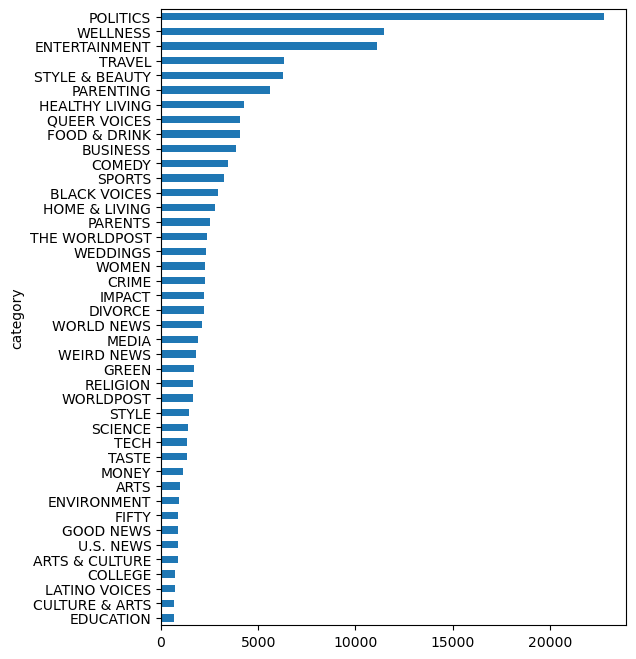

In [13]:
train['category'].value_counts().sort_values().plot(kind='barh', figsize=(6,8)); # adjust height figsize else y labels too close

This is an extremely imbalanced dataset with 42 news categories.

There are 3 major categories that account for more than 33% of the dataset:
- Politics (17.0%)
- Wellness (8.6%)
- Entertainment (8.3%)

The remaining 66% of the data consists of 39 minor categories.

The minority categories have about 600 to more than 6000 learning examples each.

The possible ways to proceed with training a classifier model are:

(1) dropping categories using various category size thresholds (e.g. <4000) to focus on the larger or more common categories. (KIV: As the smallest category has more than 600 samples, is it feasible to keep the categories and undersample the large categories?)

(2) undersampling the largest classes (Politics, Wellness, Entertainment)

(3) oversampling minority classes

(4) consolidating some or all minority classes into fewer classes (if dropping them altogether is undesirable e.g. rounded coverage of news data is required)

In [51]:
# Sample some of the categories for a feel of the data
pd.set_option('display.max_colwidth', None)

df_read = train[['category', 'headline', 'short_description']]
p = df_read.loc[
    (df_read['category']=='U.S. NEWS') |
    (df_read['category']=='WORLD NEWS')|
    (df_read['category']=='BUSINESS')|
    (df_read['category']=='TECH')|
    (df_read['category']=='POLITICS')
    ] #  BUSINESS TECH POLITICS U.S. NEWS
p.sample(20)



,category,headline,short_description
9505,POLITICS,Devin Nunes Gets Meeting On Secret Russia Probe Source After Threatening DOJ,The Republican congressman has proposed impeaching two DOJ leaders and holding a third in contempt.
73767,POLITICS,"Trump Campaign Gave Press Pass To 'Pro-White' Host, But Not Black Newspaper","“We never heard back,” newspaper’s executive editor tells TheWrap"
104303,BUSINESS,How to Communicate the Outcome of Your Assignment to Your Boss,"When presenting the outcome of your assignment, it is important to choose the right elements of the way you handled the assignment. If you don't, you face the risk of being taken for granted, not getting enough credit for the assignment OR just simply taken advantage of your work."
21778,WORLD NEWS,"Spain Just Made History -- Twice. Here's What Went Down, Hour By Hour",The government voted to strip Catalonia of its autonomy less than an hour after the region declared independence.
188786,TECH,Kindle Fire HD 4G: FCC Approval Still Needed,But they say it's very unusual for a company to announce major new products without first getting the sign-off from the agency
48953,POLITICS,Top Congress Members Call For Investigation Into Russian Interference In The Election,Leading Republicans and Democrats say there must be a congressional investigation.
102741,BUSINESS,"TheFuturein5, Episode 28: What Is the Biggest Barrier to Change?","In this episode of the Future in 5, I discuss what is the biggest barrier to change for organizations? In other words, why are some organizations not changing?"
5530,POLITICS,NYC Mayor Announces Plan To Combat Anti-Semitism Amid Slew Of Attacks,Bill de Blasio's new measures come a day after five people were injured in a stabbing while celebrating Hanukkah in a nearby suburb.
37747,POLITICS,"Mass Shooting Suspect Dies In Jail, Denying Justice For His Victims","Officials say Arcan Cetin, 20, hanged himself."
15645,POLITICS,Here's What Americans Really Think -- And Know -- About The Government Shutdown,And what they don't know.


US News: includes news from US and Canada.

There is some overlap in news content among categories, e.g. between US News and Politics; some business articles may be about technology companies and vice versa.

For certain categories, it might be worthwhile to consolidate such overlapping categories into a single category to prevent inconsistent learning and 'confused' models, especially where the objective of the model is to classify only to a single label or category. But this can be explored after checking a trained model initial predictions. 

# Headline and description lengths

In [52]:
# Function to estimate text sequence length
def string_length(s, sep=None):
  split_ls = s.split(sep)
  return len(split_ls)

In [53]:
train.loc[:, 'length_headline'] = train['headline'].apply(string_length)
train.loc[:,'length_desc'] = train['short_description'].apply(string_length)
train.head(2)

,headline,category,short_description,date,length_headline,length_desc
202836,Public Citizen Launches New Campaign Against Hospital Formula-Pack Handouts,PARENTING,"Four months ago, the AP could report that ""New mothers in Rhode Island will no longer leave the hospital with a free goody",2012-04-09,9,23
16354,NewsGuild Launches Campaign In Support Of Jailed Reuters Employees,WORLD NEWS,"""Silencing the press is an abhorrent and an intolerable act of cowardice.""",2018-01-12,9,12


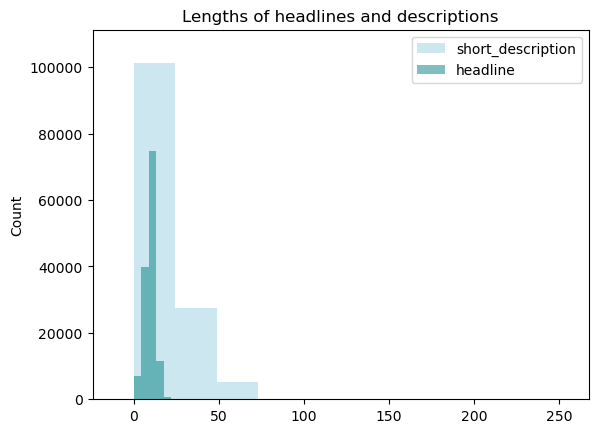

In [55]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.hist(train['length_desc'], color='lightblue', alpha=0.6, label='short_description')
ax.hist(train['length_headline'], color='teal', alpha=0.5, label='headline')
ax.legend()
ax.set(title='Lengths of headlines and descriptions', ylabel='Count')
ax.margins(0.1)
# ax.set_ylim(bottom=0)

plt.show()

Most of the headline entries and descriptions are 10 - 20 words in length (inclusive of any numbers). They are quite clean text i.e. not necessary to clean further.

In [57]:
train['date'] = pd.to_datetime(train['date'])
train['date'].min(), train['date'].max()

(Timestamp('2012-01-28 00:00:00'), Timestamp('2022-09-23 00:00:00'))

Training data articles date from Jan 2012 to Sep 2022, over almost 10 years.

In [59]:
# df.to_csv(os.path.join(root,"data_EDA.csv"), index=False)
# Save train, test and validation datasets
train.to_csv(os.path.join(root,"train.csv"), index=False)
val.to_csv(os.path.join(root,"val.csv"), index=False)
test.to_csv(os.path.join(root,"test.csv"), index=False)

In [58]:
train.columns, test.columns

(Index(['headline', 'category', 'short_description', 'date', 'length_headline',
        'length_desc'],
       dtype='object'),
 Index(['headline', 'category', 'short_description', 'date'], dtype='object'))

# Data pre-filter: minimum number of entries

In [61]:
# Function to keep the categories with a minimum number (n) of entries
cat_counts = train['category'].value_counts()

def cat_dropper(df, n):
  '''
  Takes in a dataframe, and a minimum number (n) of entries required for categories
  Drops rows belonging to categories that have less than n entries in the dataframe
  Returns dataframe with categories that have n or more entries

  '''
  df1 = df.loc[df['category'].isin(cat_counts[cat_counts >= n].index)]
  print(f"Number of rows dropped = {len(df)- len(df1)}")
  return df1

In [82]:
df1 = cat_dropper(train, 3000) # Drop categories with <4000 entries
df1.head(2)

Number of rows dropped = 47529


,headline,category,short_description,date,length_headline,length_desc
202836,Public Citizen Launches New Campaign Against Hospital Formula-Pack Handouts,PARENTING,"Four months ago, the AP could report that ""New mothers in Rhode Island will no longer leave the hospital with a free goody",2012-04-09,9,23
74670,Bernie Sanders Predicts He'll Pull Off 'One Of The Great Political Upsets' In History,POLITICS,"""We have the momentum.""",2016-02-21,14,4


In [83]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 86567 entries, 202836 to 188306
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   headline           86567 non-null  object        
 1   category           86567 non-null  object        
 2   short_description  86567 non-null  object        
 3   date               86567 non-null  datetime64[ns]
 4   length_headline    86567 non-null  int64         
 5   length_desc        86567 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 4.6+ MB


In [84]:
df1.category.nunique()

12

In [86]:
df1.category.value_counts()

category
POLITICS          22785
WELLNESS          11485
ENTERTAINMENT     11111
TRAVEL             6336
STYLE & BEAUTY     6281
PARENTING          5626
HEALTHY LIVING     4284
QUEER VOICES       4062
FOOD & DRINK       4057
BUSINESS           3835
COMEDY             3456
SPORTS             3249
Name: count, dtype: int64

At this point of experimentation, we decide to drop minor categories with less than 3000 records. There is still imbalance in the dataset, albeit less pronounced. We can explore sampling techniques (e.g. random oversampling) to deal with this.


As the headlines are rather short, we will concatenate them with the short descriptions, to enrich the information present for each article. 

In [87]:
df1[['headline', 'short_description','category', ]].sample(10)

,headline,short_description,category
16237,Kim Kardashian And Kanye West Welcome Baby Girl Via Surrogate,"The superstar couple celebrated a ""beautiful baby girl.""",ENTERTAINMENT
184451,Italy Bans Novartis Flu Vaccines Pending Tests For Side Effects,"""Given the current unclear situation Swissmedic has issued a halt to deliveries for the cited vaccines and recommends not",WELLNESS
190989,Zara Sizes Are Considered Too Small For Americans,"An article from The Economist published in late March has resurfaced online, and the closer look has allowed the fashion",STYLE & BEAUTY
40292,Fired U.S. Attorney Preet Bharara Said to Have Been Investigating HHS Secretary Tom Price,Trump’s head of the Department of Health and Human Services traded stocks of health-related companies while working on legislation affecting the firms.,POLITICS
91560,How Frat Hazing Inspired A Book About Sex Between Straight Guys,"""Not Gay"" author Jane Ward investigates flexible heterosexuality.",QUEER VOICES
118362,JPMorgan CEO Asks For Help With Data Breaches,,BUSINESS
201323,Experience The Sounds Of Lollapalooza 2012,"This year's Lollapalooza festival kicks off on August 3 in Chicago's Grant Park, and to get you in the mood, the team at Tablet has created a special 10-song preview of this year's lineup.",TRAVEL
99278,Disney Characters Have Some Surprisingly Wise Life Advice,,HEALTHY LIVING
113586,What Should An LGBTQ Person Do During The Holidays?,"Recently a colleague put me in touch with Orie Givens IV, the host of Queer Minded, to discuss issues that may be encountered by LGBTQ people during the holidays. Here are potential scenarios that could apply to you as an LGBTQ person during the holidays.",QUEER VOICES
32547,Trump-World Turns On 'Anti-Trump Special Counsel' Robert Mueller,"Despite previous compliments, the president and his supporters are now saying Robert Mueller is unfit for the job.",POLITICS


## Treatment of text with emoticons

In [88]:
# some emoticons present in short descriptions
df1.loc[147826]['short_description']

'Holiday dress season at Anthro, bye paychecks ✈️✨💰 — Taylor Lorenz (@TaylorLorenz) November 13, 2013 Life is incredible'

In [89]:
# text with apostrophe's (to check if they are retained after encode/decode)
df1.loc[110110]['short_description']

"It's been a long process over the years to get to a point where I can brush off my worries pretty quickly. Here's the steps that I follow to overcome my worries that I'd like to share with you to live a freer and less anxious life..."

- There are some non-text items like emojis in the short description e.g. at index 147826

In [90]:
# Attempt to remove emoticons/emoji's
df_test = df1.copy()

for col in df_test[['headline', 'short_description']]:
    df_test[col] = df_test[col].apply(lambda x: x.encode('unicode-escape').decode('utf-8')) #'ASCII'

#decode ASCII / utf-8: \u2708\ufe0f\u2728\U0001f4b0 \u2014 

df_test.loc[147826] #26970 #22912 147826


headline                                                                             Victoria's Secret Models Try To Sneak In Flats At The Show & More Tweets Of The Week
category                                                                                                                                                   STYLE & BEAUTY
short_description    Holiday dress season at Anthro, bye paychecks \u2708\ufe0f\u2728\U0001f4b0 \u2014 Taylor Lorenz (@TaylorLorenz) November 13, 2013 Life is incredible
date                                                                                                                                                  2013-11-16 00:00:00
length_headline                                                                                                                                                        17
length_desc                                                                                                                                           

In [91]:
emo = df_test.loc[df_test['short_description'].str.contains(r'\\U00\S+', regex=True)]
emo # 224 rows with emoji's

,headline,category,short_description,date,length_headline,length_desc
55042,Arnold Schwarzenegger Shares Sweet Oktoberfest Photo For Son Joseph Baena's Birthday,ENTERTAINMENT,Prost! \U0001f37b,2016-10-03,11,2
46459,California Bans Its Employees From Traveling To States With Anti-LGBTQ Laws,QUEER VOICES,\U0001f64c \U0001f64c \U0001f64c,2017-01-09,11,3
73381,Hayden Panettiere Flashes A Big Smile During Family Beach Day,ENTERTAINMENT,\U0001f60a\U0001f334\U0001f30a\U0001f49e\U0001f46a,2016-03-07,10,1
52179,This May Be The Most Sweeping Set Of Animal Protections Ever Announced,BUSINESS,Tens of millions of animals will be spared from suffering. \U0001f414,2016-11-03,12,11
67206,Donald Trump Says It's Up To States To 'Protect' Transgender Rights,QUEER VOICES,Because that's definitely what North Carolina is doing \U0001f612,2016-05-17,11,9
...,...,...,...,...,...,...
69628,23 Signs You're Actually In A Relationship With Food,COMEDY,Who needs a bae when you have baecon? \U0001f445 \U0001f4a6,2016-04-19,9,10
83077,41 Times The Internet Nailed How You Feel About Thanksgiving,COMEDY,Can we eat yet?! \U0001f357\U0001f356,2015-11-17,10,5
11356,Emily Blunt Says It Was Love At First Sight With Hubby John Krasinski,ENTERTAINMENT,SWOON! \U0001f495,2018-04-06,13,2
10025,Protestors Want Green Day's 'American Idiot' To Top UK Chart For Trump Visit,POLITICS,\U0001f3a4 Don't wanna be an American idiot... \U0001f3a4,2018-05-01,13,8


In [92]:
emo.category.value_counts()

category
ENTERTAINMENT     104
POLITICS           50
QUEER VOICES       35
TRAVEL             21
COMEDY             19
SPORTS             12
HEALTHY LIVING     11
BUSINESS            5
STYLE & BEAUTY      3
Name: count, dtype: int64

In [93]:
# text with apostrophe's (to check if they are retained after encode/decode)
df_test.loc[110110]['short_description']

"It's been a long process over the years to get to a point where I can brush off my worries pretty quickly. Here's the steps that I follow to overcome my worries that I'd like to share with you to live a freer and less anxious life..."

In [94]:
# text with apostrophe's or quotes
quo = df_test.loc[df_test['short_description'].str.contains(r'\\u\S+', regex=True)]
len(quo)

6894

In [111]:
quo.sample(10)

,headline,category,short_description,date,length_headline,length_desc
38556,California Lawmakers Approve Gas Tax To Pay For $52 Billion Infrastructure Plan,POLITICS,California\u2019s transportation systems have gone unrepaired and unexpanded for decades.,2017-04-07,12,10
61308,Star Trek Beyond Cast Arrives At World Premiere Comic-Con 2016,ENTERTAINMENT,"To give Comic-Con 2016 fans a sneak peek of \u201cStar Trek Beyond\u201d (released today in theaters), the cast and executives lined",2016-07-23,10,21
154547,Friday Box Office Pushes 'Riddick' Ahead Of One Direction Doc,ENTERTAINMENT,"Vin Diesel's passion project ""Riddick"" isn't earning ""Fast & Furious""-sized numbers, but the sci-fi sequel to 2004\u2032s ""The",2013-09-07,10,18
4462,\u2018Mythbuster\u2019 Grant Imahara Dead At 49,ENTERTAINMENT,"""Working with Grant was so much fun,"" former co-host Adam Savage said. ""I\u2019ll miss my friend.""",2020-07-14,6,16
42583,Getting Rid Of Trump 'Easy': Neither Impeachment Nor 25th Amendment Required,POLITICS,"Quo usque tandem abutere, Catalina, patentia nostra? (How long, Cataline, will you abuse our patience)\u2014Cicero It is very",2017-02-20,11,18
30134,Dakota Access Company Cozied Up To Ohio Officials. Then A Pollution Nightmare Began.,POLITICS,Newly released documents related to its Rover pipeline give weight to critics who call Energy Transfer Partners a \u201cwolf in sheep\u2019s clothing.\u201d,2017-07-15,13,22
42838,Trump: Making America Divided Again,POLITICS,Trump\u2019s latest press conference is worrisome for so many reasons. \xa0He seems to live in his own reality (e.g. his administration,2017-02-17,5,21
67242,HUFFPOLLSTER: Trump Supporters Are More Likely Than Other Republicans To Dislike Minorities,POLITICS,"\u201cFor these voters, Trump\u2019s blend of casual racism and muscular nativism is the core of his appeal.\u201d",2016-05-17,12,17
181519,LIPA Customers Left Without Power For Weeks Sent Normal Electric Bills Despite Blackouts,BUSINESS,"According to Bloomberg, two customers accuse LIPA of failing to provide electric services because of its \u201cdisregard\u201d in management",2012-11-25,13,19
16867,What The Bernie Sanders Winter Coat Controversy Gets Wrong About Socialism,POLITICS,"\u201cEveryone deserves to be wearing a nice coat like Bernie Sanders,\u201d said a prominent democratic socialist.",2018-01-06,11,16


As there are only 200+ rows with emojis/emoticons, it is easier at this point to just drop these rows from the original dataframe, after they are detected. Based on the value counts above, the number of dropped data rows are an insignificant fraction.

However after trying to decode/encode to detect for emoji's , some text with apostrophes and quote marks then show up as wrongly encoded ("\u2019") There are about 6K rows with such issues. 

It was verified that these can be solved by specifying encoding ='utf-8' when reading in the CSV. However, we still need a more efficient method to clean up the emojis. Possible solutions are here: https://stackoverflow.com/questions/51217909/removing-all-emojis-from-text


In [96]:
# Drop rows with emoji's
df2 = df1[~df1.index.isin(emo.index)]
len(df2)

86307

In [98]:
# List of categories to train for
df2.category.unique() # 12 cats

array(['PARENTING', 'POLITICS', 'ENTERTAINMENT', 'WELLNESS', 'BUSINESS',
       'TRAVEL', 'FOOD & DRINK', 'QUEER VOICES', 'STYLE & BEAUTY',
       'HEALTHY LIVING', 'SPORTS', 'COMEDY'], dtype=object)

## Join headline with short description

- Some short_description are blank, but for most rows, the short description provides more information or context on the headline. Thus it would be helpful to join headline with description for richer text input. 

In [99]:
# Concatenate headline and short description into 'text' column
df2.loc[:,'text'] = df2['headline'] + ' ' + df2['short_description']

/var/folders/n7/b9vhk3fd5c7f4sz6xl8w1frw0000gn/T/ipykernel_1466/2920628707.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2.loc[:,'text'] = df2['headline'] + ' ' + df2['short_description']


In [100]:
df2.sample()

,headline,category,short_description,date,length_headline,length_desc,text
190186,Taking A Break In Big Sur (PHOTOS),TRAVEL,Tassajara is an incredible place where there are stunning hot springs deep inside the heart of the mountains.,2012-08-23,7,18,Taking A Break In Big Sur (PHOTOS) Tassajara is an incredible place where there are stunning hot springs deep inside the heart of the mountains.


In [103]:
# Export selected columns of processed dataset
df2 = df2[['headline', 'category', 'short_description', 'text', 'date', 'length_headline', 'length_desc']]
df2.to_csv(os.path.join(root, "train_processed_12cats.csv"), index=False)

In [102]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 86307 entries, 202836 to 188306
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   headline           86307 non-null  object        
 1   category           86307 non-null  object        
 2   short_description  86307 non-null  object        
 3   text               86307 non-null  object        
 4   date               86307 non-null  datetime64[ns]
 5   length_headline    86307 non-null  int64         
 6   length_desc        86307 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(4)
memory usage: 5.3+ MB


Based on the above exploration, the preprocessing steps on training text inputs are:
1. Keep only target categories 
   ['PARENTING', 'POLITICS', 'ENTERTAINMENT', 'WELLNESS', 'BUSINESS',
       'TRAVEL', 'FOOD & DRINK', 'QUEER VOICES', 'STYLE & BEAUTY',
       'HEALTHY LIVING', 'SPORTS', 'COMEDY']
2. Join headline with short_description

Optionally:

3. Remove entries with emojis or emoticons (encode and decode)
4. Remove by regex \u201c \u201d \u2019 

This has to be done separately on the validation and test datasets as well.